In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

# change path to parent directory for paths
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm
from einops import rearrange

from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.losses import latent_regularizer
from ldns.networks import Denoiser
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler

import lovely_tensors as lt
lt.monkey_patch()

matplotlib.rc_file('matplotlibrc')


In [ ]:
## load config and model path

cfg_ae = OmegaConf.load("conf/autoencoder-human.yaml")


cfg_yaml = """
denoiser_model:
  C_in: 32
  C: 384
  kernel: s4
  num_blocks: 6
  bidirectional: True
  num_train_timesteps: 1000
training:
  lr: 0.001
  num_epochs: 2000
  num_warmup_epochs: 100
  batch_size: 256
  random_seed: 42
  precision: "no"
exp_name: diffusion_human
"""
cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
cfg.dataset = cfg_ae.dataset


In [4]:

from ldns.data.human import get_human_dataloaders

# set seed
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

train_dataloader, val_dataloader, test_dataloader = get_human_dataloaders(
        cfg_ae.dataset.datapath, batch_size=cfg_ae.training.batch_size
    )


Data path: data/human/competitionData
Train: 8417, Val: 213, Test: 640


In [ ]:
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.max_seqlen,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.get("num_blocks_decoder", cfg_ae.model.num_blocks),
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
    bidirectional=cfg_ae.model.get("bidirectional", False),
)

ae_model = CountWrapper(ae_model)
ae_model.load_state_dict(torch.load(f"exp/{cfg_ae.exp_name}/model.pt"))

accelerator = accelerate.Accelerator(
    mixed_precision="no",
)

ae_model = accelerator.prepare(ae_model)
print(cfg_ae.exp_name)

(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

In [ ]:
from ldns.data.human import LatentHumanDataset

# create training dataset
latent_dataset_train = LatentHumanDataset(train_dataloader, ae_model, clip=False)

# create validation and test datasets using training set statistics
latent_dataset_val = LatentHumanDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)
latent_dataset_test = LatentHumanDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

In [8]:
display(latent_dataset_train[0])
display(latent_dataset_train[1])

element = latent_dataset_train[0]

{'signal': tensor[128, 512] n=65536 (0.2Mb) x∈[0., 6.000] μ=0.421 σ=0.747,
 'latent': tensor[48, 512] n=24576 (96Kb) x∈[-2.907, 2.980] μ=-0.154 σ=0.891,
 'mask': tensor[1, 512] 2Kb x∈[0., 1.000] μ=0.648 σ=0.478}

{'signal': tensor[128, 512] n=65536 (0.2Mb) x∈[0., 9.000] μ=0.354 σ=0.717,
 'latent': tensor[48, 512] n=24576 (96Kb) x∈[-2.887, 3.879] μ=0.049 σ=0.971,
 'mask': tensor[1, 512] 2Kb x∈[0., 1.000] μ=0.582 σ=0.494}

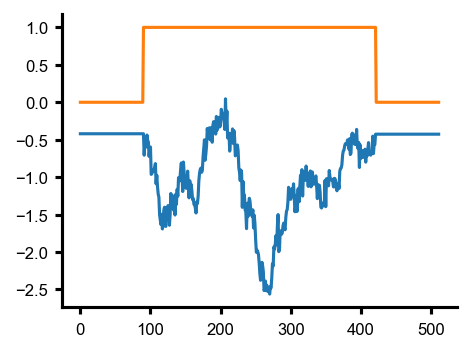

In [9]:
plt.plot(element['latent'][0])
plt.plot(element['mask'][0])

# mask and (padded) latents visualized

In [12]:
train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)

# check if signal length is power of 2
if cfg.dataset.max_seqlen & (cfg.dataset.max_seqlen - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    train_latent_dataloader,
    val_latent_dataloader,
) = accelerator.prepare(
    train_latent_dataloader,
    val_latent_dataloader,
)


In [15]:

## initialize denoiser

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in + 1, # 1 for mask (length of required latent)
    C=cfg.denoiser_model.C,
    L=cfg.dataset.max_seqlen,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

# initial values may be way off so better to scale down the output layer
denoiser.conv_out.weight.data = denoiser.conv_out.weight.data * 0.1
denoiser.conv_out.bias.data = denoiser.conv_out.bias.data * 0.1

    
scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
    clip_sample=False,
    beta_schedule="linear",
)


optimizer = torch.optim.AdamW(
    denoiser.parameters(), lr=cfg.training.lr
)  # default wd=0.01 for now



num_batches = len(train_latent_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches * cfg.training.num_epochs * 1.3,  # total number of steps
)

# prepare the denoiser model and dataset
(
    denoiser,
    optimizer,
    lr_scheduler,
) = accelerator.prepare(
    denoiser,
    optimizer,
    lr_scheduler,
)

ema_model = EMAModel(denoiser, min_value=0.9999)


In [16]:

from ldns.utils import count_parameters

print(count_parameters(denoiser)/1e6, "M parameters")


denoiser


5.688417 M parameters


 Denoiser(
   (conv_in): Conv1d(33, 384, kernel_size=(1,), stride=(1,))
   (blocks): ModuleList(
     (0-5): 6 x DenoiserBlock(
       (time_mixer): FFTConv(
         (activation): Identity()
         (kernel): SSMKernelDPLR()
         (drop): Identity()
         (drop_kernel): Identity()
       )
       (channel_mixer): Sequential(
         (0): Rearrange('b c l -> b l c')
         (1): Linear(in_features=384, out_features=768, bias=True)
         (2): GELU(approximate='none')
         (3): Linear(in_features=768, out_features=384, bias=True)
         (4): Rearrange('b l c -> b c l')
       )
       (norm1): InstanceNorm1d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (norm2): InstanceNorm1d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (act1): GELU(approximate='none')
       (act2): Identity()
       (ada_ln): Sequential(
         (0): GELU(approximate='none')
         (1): Linear(in_features=96, out_features=2304, bias=

In [17]:
def sample_spikes_with_mask(ema_denoiser, scheduler, ae, cfg, lengths=None, batch_size=1, device="cuda"):
    """Sample spike trains from the diffusion model with variable length masks.
    
    Uses DDPM sampling with EMA-averaged model to generate latents, which are then 
    decoded to rates and spikes. 
    Args:
        ema_denoiser: EMA-averaged denoiser model
        scheduler: DDPM scheduler for sampling
        ae: Trained autoencoder for decoding latents to rates
        cfg: Config object with model parameters
        lengths: Optional list/tensor of sequence lengths for masks
        batch_size: Number of samples to generate
        device: Device to run sampling on
        
    Returns:
        dict containing:
            rates: Generated firing rates
            spikes: Sampled spike trains
            latents: Generated latents
            masks: Generated masks
            mask_lengths: Lengths used for masks
    """
    # start with random noise matching model input shape
    z_t = torch.randn(
        (batch_size, cfg.denoiser_model.C_in, cfg.dataset.max_seqlen)
    ).to(device)

    # generate lengths for masks if not provided
    if lengths is None:
        lengths = torch.linspace(100, 512, batch_size).long().to(device)
    else:
        if isinstance(lengths, int):
            lengths = torch.tensor([lengths] * batch_size).to(device)
        elif isinstance(lengths, list):
            lengths = torch.tensor(lengths).long().to(device)
    
    # create masks with 1s in center and 0s for padding
    masks = torch.zeros(batch_size, cfg.dataset.max_seqlen).to(device)
    for i, l in enumerate(lengths):
        padding_left = (cfg.dataset.max_seqlen - l) // 2
        padding_right = cfg.dataset.max_seqlen - l - padding_left
        masks[i, padding_left:padding_left + l] = 1.0

    masks = masks.unsqueeze(1)

    # get EMA model and prepare for inference
    ema_denoiser_avg = ema_denoiser.averaged_model
    ema_denoiser_avg.eval()
    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    # iteratively denoise using DDPM
    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM (different masks)"):
        with torch.no_grad():
            model_output = ema_denoiser_avg(
                torch.cat([z_t, masks], dim=1), torch.tensor([t] * batch_size).to(device).long()
            )[:, :-1]
        z_t = scheduler.step(model_output, t, z_t, return_dict=False)[0]

    # scale latents back to original range
    z_t = z_t * latent_dataset_train.latent_stds.to(z_t.device) + latent_dataset_train.latent_means.to(z_t.device)

    # decode latents to rates and sample spikes
    with torch.no_grad():
        rates = ae.decode(z_t).cpu()
    
    spikes = torch.poisson(rates)

    return {
        "rates": rates,
        "spikes": spikes,
        "latents": z_t.cpu(),
        "masks": masks.cpu(),
        "mask_lengths": lengths,
    }

In [18]:
def plot_real_vs_sampled_rates_and_spikes(
    real_rates,
    sampled_rates,
    real_spikes,
    sampled_spikes,
    real_masks,
    sampled_masks,
    batch_idx=0,
):
    """Plot real and sampled rates and spikes side by side for comparison.
    
    Args:
        real_rates (torch.Tensor): Ground truth firing rates [batch, channels, length]
        sampled_rates (torch.Tensor): Model generated firing rates [batch, channels, length] 
        real_spikes (torch.Tensor): Ground truth spike trains [batch, channels, length]
        sampled_spikes (torch.Tensor): Model generated spike trains [batch, channels, length]
        real_masks (torch.Tensor): Masks for real data [batch, 1, length]
        sampled_masks (torch.Tensor): Masks for sampled data [batch, 1, length]
        batch_idx (int): Which batch element to plot. Defaults to 0.
    """
    B, C, L = real_rates.shape

    # create 2x2 subplot with appropriate size
    fig, axs = plt.subplots(2, 2, figsize=cm2inch(12, 8), dpi=300)

    # select single batch element to plot
    real_rates = real_rates[batch_idx]
    sampled_rates = sampled_rates[batch_idx]
    real_spikes = real_spikes[batch_idx]
    sampled_spikes = sampled_spikes[batch_idx]
    real_masks = real_masks[batch_idx]
    sampled_masks = sampled_masks[batch_idx]

    # get indices where mask is 1 (non-padding)
    real_mask_idx_with_1 = torch.arange(real_masks[0].nonzero().flatten().numel())
    sampled_mask_idx_with_1 = sampled_masks[0].nonzero().flatten()

    # plot real rates with colorbar
    im = axs[0, 0].imshow(real_rates[:, real_mask_idx_with_1], cmap="viridis", alpha=1.0, aspect="auto")
    axs[0, 0].set_title("Real rates")
    fig.colorbar(im, ax=axs[0, 0], orientation="vertical", fraction=0.046, pad=0.04)

    # plot sampled rates with colorbar
    im = axs[0, 1].imshow(
        sampled_rates[:, sampled_mask_idx_with_1], cmap="viridis", alpha=1.0, aspect="auto"
    )
    axs[0, 1].set_title("Sampled rates") 
    fig.colorbar(im, ax=axs[0, 1], orientation="vertical", fraction=0.046, pad=0.04)

    # plot real spikes with colorbar
    im = axs[1, 0].imshow(real_spikes[:, real_mask_idx_with_1], cmap="Greys", alpha=1.0, aspect="auto")
    axs[1, 0].set_title("Real spikes")
    fig.colorbar(im, ax=axs[1, 0], orientation="vertical", fraction=0.046, pad=0.04)

    # plot sampled spikes with colorbar
    im = axs[1, 1].imshow(
        sampled_spikes[:, sampled_mask_idx_with_1], cmap="Greys", alpha=1.0, aspect="auto"
    )
    axs[1, 1].set_title("Sampled spikes")
    fig.colorbar(im, ax=axs[1, 1], orientation="vertical", fraction=0.046, pad=0.04)

    # print shapes for debugging
    print(
        real_rates[:, real_mask_idx_with_1].shape,
        sampled_rates[:, sampled_mask_idx_with_1].shape,
        real_spikes[:, real_mask_idx_with_1].shape,
        sampled_spikes[:, sampled_mask_idx_with_1].shape,
    )

    # remove y-ticks from right plots for cleaner visualization
    for i, ax in enumerate(axs.flatten()):
        if i% 2 != 0:
            ax.set_yticks([])

    fig.tight_layout()
    plt.show()


In [19]:
# define loss function - smooth L1 loss with small beta for faster convergence
loss_fn = torch.nn.SmoothL1Loss(beta=0.04, reduction="none")

# training loop
pbar = tqdm(range(0, cfg.training.num_epochs), desc="epochs")
for epoch in pbar:
    for i, batch in enumerate(train_latent_dataloader):
        denoiser.train()
        optimizer.zero_grad()

        # get latent vectors and masks from batch
        z = batch["latent"] 
        z_mask = batch["mask"]

        # sample random timesteps
        t = torch.randint(
            0, cfg.denoiser_model.num_train_timesteps, (z.shape[0],), device="cpu"
        ).long()

        # add noise to latents according to timestep
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, t)

        # predict noise and remove mask dimension
        noise_pred = denoiser(torch.cat([noisy_z, z_mask], dim=1), t)
        noise_pred = noise_pred[:,:-1] # remove mask conditioning dim

        # compute masked loss
        loss = loss_fn(noise, noise_pred)
        loss = loss * z_mask  # zero out loss for padding
        loss = loss.mean()

        # optimization step
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(denoiser.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

        # update progress bar
        if i % 10 == 0:
            pbar.set_postfix(
                {
                    "loss": loss.item(),
                    "lr": lr_scheduler.get_last_lr()[0],
                    "epoch": epoch,
                }
            )

        # update EMA model
        ema_model.step(denoiser)

    # generate and plot samples every 50 epochs
    if (epoch) % 50 == 0:
        denoiser.eval()

        # get validation batch and generate samples
        val_batch = next(iter(val_latent_dataloader))
        val_batch['mask'][:2,0].sum(-1)
        ret_dict = sample_spikes_with_mask(ema_model,
                                           scheduler, 
                                           ae_model, 
                                           cfg, 
                                           lengths=[int(i.item()) for i in val_batch['mask'][:2,0].sum(-1)], 
                                           batch_size=2, 
                                           device=("cuda" if torch.cuda.is_available() else "cpu")
        )
        
        with torch.no_grad():
            val_batch_rates = ae_model(val_batch["signal"])[0].cpu()

        # plot real vs generated samples for first two items in batch
        plot_real_vs_sampled_rates_and_spikes(
            val_batch_rates,
            ret_dict["rates"],
            val_batch["signal"].cpu(),
            ret_dict["spikes"],
            val_batch["mask"].cpu(),
            ret_dict["masks"],
            batch_idx=0,
        )
        plot_real_vs_sampled_rates_and_spikes(
            val_batch_rates,
            ret_dict["rates"],
            val_batch["signal"].cpu(),
            ret_dict["spikes"],
            val_batch["mask"].cpu(),
            ret_dict["masks"],
            batch_idx=1,
        )

pbar.close()

In [23]:
# save model
os.makedirs(f"exp/{cfg.exp_name}", exist_ok=True)
torch.save(ema_model.averaged_model.state_dict(), f"exp/{cfg.exp_name}/model.pt")

We evaluate the model in `notebooks/plotting_diffusion_human.ipynb`